# 🧠 Neural Network Models for Churn Prediction
## (MLP, TabNet, FT-Transformer)

**استراتژی:**
- 👤 **1 Order Users (45%):** XGBoost (بدون پترن رفتاری)
- 👥 **2+ Orders Users (55%):** Neural Networks (پترن behavioral غنی)

**مدل‌های Neural Network:**
1. **MLP (DNN):** Baseline ساده
2. **TabNet:** با Attention برای Tabular Data
3. **FT-Transformer:** State-of-the-art برای Tabular

---

## 0️⃣ Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split

# XGBoost for 1-order users
from xgboost import XGBClassifier

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')

print('✅ Libraries loaded!')

Using device: cuda
✅ Libraries loaded!


In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    'data_dir': '../data/processed',
    'results_dir': '../experiments/neural_networks',
    
    # Training params
    'batch_size': 256,
    'epochs': 100,
    'patience': 15,  # Early stopping
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    
    # Validation split from train
    'val_size': 0.15,
    
    'random_state': 42
}

os.makedirs(CONFIG['results_dir'], exist_ok=True)

print('✅ Configuration loaded!')

✅ Configuration loaded!


---
## 1️⃣ Load & Prepare Data

In [4]:
print('📂 Loading data...')

train_df = pd.read_csv(f'{CONFIG["data_dir"]}/train_features.csv')
test_df = pd.read_csv(f'{CONFIG["data_dir"]}/test_features.csv')

with open(f'{CONFIG["data_dir"]}/feature_columns.txt', 'r') as f:
    feature_cols = [line.strip() for line in f.readlines()]

print(f'   Train: {len(train_df):,} users')
print(f'   Test:  {len(test_df):,} users')
print(f'   Features: {len(feature_cols)}')

📂 Loading data...
   Train: 265,962 users
   Test:  261,889 users
   Features: 98


In [5]:
# Segment distribution
print('\n📊 Segment Distribution:')
for df, name in [(train_df, 'Train'), (test_df, 'Test')]:
    print(f'\n{name}:')
    dist = df['frequency_segment'].value_counts()
    for seg, count in dist.items():
        pct = count / len(df) * 100
        print(f'   {seg}: {count:,} ({pct:.1f}%)')


📊 Segment Distribution:

Train:
   1 Order: 115,224 (43.3%)
   2-4 Orders: 69,478 (26.1%)
   5-10 Orders: 44,860 (16.9%)
   11-30 Orders: 29,960 (11.3%)
   30+ Orders: 6,440 (2.4%)

Test:
   1 Order: 110,678 (42.3%)
   2-4 Orders: 67,312 (25.7%)
   5-10 Orders: 44,836 (17.1%)
   11-30 Orders: 31,572 (12.1%)
   30+ Orders: 7,491 (2.9%)


In [6]:
# Split into two groups: 1-Order and 2+ Orders
print('='*70)
print('📦 Splitting Data into Two Groups')
print('='*70)

# 1-Order users
train_1order = train_df[train_df['frequency_segment'] == '1 Order'].copy()
test_1order = test_df[test_df['frequency_segment'] == '1 Order'].copy()

# 2+ Orders users
train_multi = train_df[train_df['frequency_segment'] != '1 Order'].copy()
test_multi = test_df[test_df['frequency_segment'] != '1 Order'].copy()

print(f'''
📊 Group Statistics:

👤 1-Order Users (→ XGBoost):
   Train: {len(train_1order):,} ({train_1order["is_churned"].mean()*100:.1f}% churn)
   Test:  {len(test_1order):,} ({test_1order["is_churned"].mean()*100:.1f}% churn)

👥 2+ Orders Users (→ Neural Networks):
   Train: {len(train_multi):,} ({train_multi["is_churned"].mean()*100:.1f}% churn)
   Test:  {len(test_multi):,} ({test_multi["is_churned"].mean()*100:.1f}% churn)
   
   Segments included:
''')
for seg in train_multi['frequency_segment'].unique():
    n = (train_multi['frequency_segment'] == seg).sum()
    print(f'      - {seg}: {n:,}')

📦 Splitting Data into Two Groups

📊 Group Statistics:

👤 1-Order Users (→ XGBoost):
   Train: 115,224 (87.8% churn)
   Test:  110,678 (85.4% churn)

👥 2+ Orders Users (→ Neural Networks):
   Train: 150,738 (42.7% churn)
   Test:  151,211 (39.2% churn)
   
   Segments included:

      - 11-30 Orders: 29,960
      - 2-4 Orders: 69,478
      - 30+ Orders: 6,440
      - 5-10 Orders: 44,860


In [7]:
# Encode categorical features
print('\n🔧 Encoding categorical features...')

label_encoders = {}
categorical_cols = []

for col in feature_cols:
    if col in train_df.columns and train_df[col].dtype == 'object':
        categorical_cols.append(col)
        le = LabelEncoder()
        combined = pd.concat([train_df[col], test_df[col]]).astype(str)
        le.fit(combined)
        
        train_1order[col] = le.transform(train_1order[col].astype(str))
        test_1order[col] = le.transform(test_1order[col].astype(str))
        train_multi[col] = le.transform(train_multi[col].astype(str))
        test_multi[col] = le.transform(test_multi[col].astype(str))
        
        label_encoders[col] = le

print(f'   Encoded columns: {categorical_cols}')


🔧 Encoding categorical features...
   Encoded columns: []


In [8]:
# Prepare features for Neural Networks (2+ orders)
print('\n🔧 Preparing data for Neural Networks...')

# Add segment as numeric feature for NN
segment_encoder = LabelEncoder()
segment_encoder.fit(train_multi['frequency_segment'])

# Features for multi-order users
X_train_multi = train_multi[feature_cols].fillna(0).values
y_train_multi = train_multi['is_churned'].values
segment_train = segment_encoder.transform(train_multi['frequency_segment'])

X_test_multi = test_multi[feature_cols].fillna(0).values
y_test_multi = test_multi['is_churned'].values
segment_test = segment_encoder.transform(test_multi['frequency_segment'])

# Scale features
scaler = StandardScaler()
X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

# Split train into train/val
X_train_nn, X_val_nn, y_train_nn, y_val_nn, seg_train_nn, seg_val_nn = train_test_split(
    X_train_multi_scaled, y_train_multi, segment_train,
    test_size=CONFIG['val_size'],
    random_state=RANDOM_STATE,
    stratify=y_train_multi
)

print(f'''
📊 Neural Network Data:
   Train: {len(X_train_nn):,}
   Val:   {len(X_val_nn):,}
   Test:  {len(X_test_multi_scaled):,}
   Features: {X_train_nn.shape[1]}
''')


🔧 Preparing data for Neural Networks...

📊 Neural Network Data:
   Train: 128,127
   Val:   22,611
   Test:  151,211
   Features: 98



In [9]:
# Create PyTorch DataLoaders
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size, use_weighted_sampler=True):
    """
    Create DataLoaders with optional weighted sampling for imbalanced data.
    """
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    # Weighted sampler for imbalanced data
    if use_weighted_sampler:
        class_counts = np.bincount(y_train.astype(int))
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[y_train.astype(int)]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

# Create loaders
train_loader, val_loader, test_loader = create_dataloaders(
    X_train_nn, y_train_nn, X_val_nn, y_val_nn,
    X_test_multi_scaled, y_test_multi,
    batch_size=CONFIG['batch_size']
)

print('✅ DataLoaders created!')

✅ DataLoaders created!


---
## 2️⃣ Model Architectures

### 2.1 MLP (Deep Neural Network)

In [10]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron for Tabular Data.
    
    Architecture:
    - Input → BatchNorm → Dense layers with dropout
    - Skip connections for better gradient flow
    - GELU activation (smoother than ReLU)
    """
    
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super(MLP, self).__init__()
        
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.input_bn(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x.squeeze(-1)

print('✅ MLP model defined!')

✅ MLP model defined!


### 2.2 TabNet

In [11]:
class GLUBlock(nn.Module):
    """Gated Linear Unit Block."""
    
    def __init__(self, input_dim, output_dim, virtual_batch_size=None):
        super(GLUBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim * 2)
        self.bn = nn.BatchNorm1d(output_dim * 2)
        self.output_dim = output_dim
    
    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x, gate = x.chunk(2, dim=-1)
        return x * torch.sigmoid(gate)


class AttentiveTransformer(nn.Module):
    """Attention mechanism for feature selection."""
    
    def __init__(self, input_dim, output_dim):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
    
    def forward(self, x, priors):
        x = self.fc(x)
        x = self.bn(x)
        x = x * priors
        return F.softmax(x, dim=-1)


class TabNet(nn.Module):
    """
    TabNet: Attentive Interpretable Tabular Learning.
    
    Key features:
    - Sequential attention for feature selection
    - Instance-wise feature selection
    - Interpretable (can see which features are important)
    """
    
    def __init__(self, input_dim, n_steps=3, n_d=64, n_a=64, 
                 gamma=1.3, relaxation_factor=1.5):
        super(TabNet, self).__init__()
        
        self.input_dim = input_dim
        self.n_steps = n_steps
        self.n_d = n_d
        self.n_a = n_a
        self.gamma = gamma
        
        # Initial batch norm
        self.initial_bn = nn.BatchNorm1d(input_dim)
        
        # Shared layers
        self.shared_fc = nn.Linear(input_dim, n_d + n_a)
        self.shared_bn = nn.BatchNorm1d(n_d + n_a)
        
        # Step-specific layers
        self.step_attentions = nn.ModuleList([
            AttentiveTransformer(n_a, input_dim) for _ in range(n_steps)
        ])
        
        self.step_fcs = nn.ModuleList([
            GLUBlock(input_dim, n_d + n_a) for _ in range(n_steps)
        ])
        
        # Final output
        self.final_fc = nn.Linear(n_d, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initial transform
        x = self.initial_bn(x)
        x_init = x
        
        # Prior scales (initialized to 1)
        prior_scales = torch.ones(batch_size, self.input_dim, device=x.device)
        
        # Aggregated output
        output_aggregate = torch.zeros(batch_size, self.n_d, device=x.device)
        
        # Process steps
        for step in range(self.n_steps):
            # Feature transform
            if step == 0:
                h = self.shared_fc(x_init)
                h = self.shared_bn(h)
                h = F.relu(h)
            else:
                # Masked features
                masked_x = x_init * mask
                h = self.step_fcs[step](masked_x)
            
            # Split into decision and attention
            d, a = h[:, :self.n_d], h[:, self.n_d:]
            
            # Attention for next step
            mask = self.step_attentions[step](a, prior_scales)
            
            # Update prior scales
            prior_scales = prior_scales * (self.gamma - mask)
            
            # Aggregate decision
            output_aggregate = output_aggregate + d
        
        # Final output
        out = self.final_fc(output_aggregate)
        return out.squeeze(-1)

print('✅ TabNet model defined!')

✅ TabNet model defined!


### 2.3 FT-Transformer

In [12]:
class FeatureTokenizer(nn.Module):
    """Convert numerical features to embeddings."""
    
    def __init__(self, num_features, d_token):
        super(FeatureTokenizer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(num_features, d_token))
        self.bias = nn.Parameter(torch.Tensor(num_features, d_token))
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        nn.init.zeros_(self.bias)
    
    def forward(self, x):
        # x: (batch, num_features)
        # output: (batch, num_features, d_token)
        x = x.unsqueeze(-1)  # (batch, num_features, 1)
        return x * self.weight + self.bias


class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention."""
    
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Linear projections
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.W_o(context)


class TransformerBlock(nn.Module):
    """Transformer encoder block."""
    
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Self-attention with residual
        attn_out = self.attention(x)
        x = self.norm1(x + self.dropout(attn_out))
        
        # FFN with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class FTTransformer(nn.Module):
    """
    FT-Transformer: Feature Tokenizer + Transformer.
    
    Key features:
    - Each feature becomes a token
    - [CLS] token for classification
    - Self-attention learns feature interactions
    - State-of-the-art for tabular data
    """
    
    def __init__(self, num_features, d_token=64, n_blocks=3, n_heads=4, 
                 d_ff_multiplier=2, dropout=0.2):
        super(FTTransformer, self).__init__()
        
        self.num_features = num_features
        self.d_token = d_token
        
        # Feature tokenizer
        self.tokenizer = FeatureTokenizer(num_features, d_token)
        
        # [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Transformer blocks
        d_ff = d_token * d_ff_multiplier
        self.blocks = nn.ModuleList([
            TransformerBlock(d_token, n_heads, d_ff, dropout)
            for _ in range(n_blocks)
        ])
        
        # Output head
        self.norm = nn.LayerNorm(d_token)
        self.head = nn.Sequential(
            nn.Linear(d_token, d_token),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_token, 1)
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Tokenize features: (batch, num_features, d_token)
        tokens = self.tokenizer(x)
        
        # Add [CLS] token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat([cls_tokens, tokens], dim=1)
        
        # Apply transformer blocks
        for block in self.blocks:
            tokens = block(tokens)
        
        # Use [CLS] token for classification
        cls_output = tokens[:, 0]
        cls_output = self.norm(cls_output)
        
        # Output
        out = self.head(cls_output)
        return out.squeeze(-1)

print('✅ FT-Transformer model defined!')

✅ FT-Transformer model defined!


---
## 3️⃣ Training & Evaluation Functions

In [13]:
class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=10, min_delta=0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.counter = 0
        self.best_score = None
        self.best_weights = None
        self.early_stop = False
    
    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
    
    def restore(self, model):
        if self.restore_best and self.best_weights is not None:
            model.load_state_dict(self.best_weights)


def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


def evaluate(model, data_loader, criterion, device):
    """Evaluate model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, np.array(all_preds), np.array(all_probs), np.array(all_targets)


def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate comprehensive metrics."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0,
        'pr_auc': average_precision_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0
    }
    return metrics

print('✅ Training functions defined!')

✅ Training functions defined!


In [14]:
def train_model(model, train_loader, val_loader, config, model_name):
    """
    Full training loop with early stopping and learning rate scheduling.
    """
    print(f'\n{"="*60}')
    print(f'🚀 Training {model_name}')
    print(f'{"="*60}')
    
    model = model.to(DEVICE)
    
    # Loss function (with class weight for imbalance)
    pos_weight = torch.tensor([2.0]).to(DEVICE)  # Weight for positive class
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    
    # Scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5,
    )
    # ReduceLROnPlateau(
    # optimizer,
    # mode='max',              # یا 'min' برای loss
    # factor=0.5,              # ضریب کاهش (0.1 تا 0.9)
    # patience=5,              # تعداد epoch صبر
    # min_lr=1e-6,             # حداقل learning rate
    # threshold=1e-4,          # حداقل تغییر برای بهبود
    # threshold_mode='rel',    # 'rel' یا 'abs'
    # cooldown=0,              # epoch های انتظار بعد از کاهش LR
    # eps=1e-8                 # حداقل تغییر معنادار
    # )


    # Early stopping
    early_stopping = EarlyStopping(patience=config['patience'])
    
    # Training history
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_auc': []}
    
    for epoch in range(config['epochs']):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        
        # Validate
        val_loss, val_preds, val_probs, val_targets = evaluate(
            model, val_loader, criterion, DEVICE
        )
        val_metrics = calculate_metrics(val_targets, val_preds, val_probs)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['roc_auc'])
        
        # Scheduler step
        scheduler.step(val_metrics['f1'])
        
        # Early stopping
        early_stopping(val_metrics['f1'], model)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}: '
                  f'Train Loss={train_loss:.4f}, '
                  f'Val Loss={val_loss:.4f}, '
                  f'Val F1={val_metrics["f1"]:.4f}, '
                  f'Val AUC={val_metrics["roc_auc"]:.4f}')
        
        if early_stopping.early_stop:
            print(f'\n⚠️ Early stopping at epoch {epoch+1}')
            break
    
    # Restore best weights
    early_stopping.restore(model)
    
    print(f'\n✅ Training complete! Best Val F1: {early_stopping.best_score:.4f}')
    
    return model, history

print('✅ Full training function defined!')

✅ Full training function defined!


---
## 4️⃣ Train All Models

### 4.1 XGBoost for 1-Order Users

In [15]:
print('='*70)
print('🌲 Training XGBoost for 1-Order Users')
print('='*70)

# Prepare data
X_train_1order = train_1order[feature_cols].fillna(0)
y_train_1order = train_1order['is_churned']
X_test_1order = test_1order[feature_cols].fillna(0)
y_test_1order = test_1order['is_churned']

# Calculate class weight
n_churned = y_train_1order.sum()
n_active = len(y_train_1order) - n_churned
scale_pos_weight = n_active / n_churned

print(f'\nClass distribution:')
print(f'   Churned: {n_churned:,} ({n_churned/len(y_train_1order)*100:.1f}%)')
print(f'   Active:  {n_active:,} ({n_active/len(y_train_1order)*100:.1f}%)')
print(f'   scale_pos_weight: {scale_pos_weight:.2f}')

# Train XGBoost
xgb_1order = XGBClassifier(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    early_stopping_rounds=100,
    verbosity=0
)

xgb_1order.fit(
    X_train_1order, y_train_1order,
    eval_set=[(X_test_1order, y_test_1order)],
    # verbose=False
)

# Evaluate
y_pred_1order = xgb_1order.predict(X_test_1order)
y_prob_1order = xgb_1order.predict_proba(X_test_1order)[:, 1]

metrics_1order = calculate_metrics(y_test_1order, y_pred_1order, y_prob_1order)

print(f'\n📊 XGBoost Results (1-Order Users):')
for metric, value in metrics_1order.items():
    print(f'   {metric}: {value:.4f}')

🌲 Training XGBoost for 1-Order Users

Class distribution:
   Churned: 101,203 (87.8%)
   Active:  14,021 (12.2%)
   scale_pos_weight: 0.14
[0]	validation_0-logloss:0.68034
[1]	validation_0-logloss:0.67053
[2]	validation_0-logloss:0.66217
[3]	validation_0-logloss:0.65540
[4]	validation_0-logloss:0.64927
[5]	validation_0-logloss:0.64466
[6]	validation_0-logloss:0.64096
[7]	validation_0-logloss:0.63807
[8]	validation_0-logloss:0.63480
[9]	validation_0-logloss:0.63278
[10]	validation_0-logloss:0.63074
[11]	validation_0-logloss:0.62914
[12]	validation_0-logloss:0.62803
[13]	validation_0-logloss:0.62697
[14]	validation_0-logloss:0.62630
[15]	validation_0-logloss:0.62591
[16]	validation_0-logloss:0.62506
[17]	validation_0-logloss:0.62482
[18]	validation_0-logloss:0.62428
[19]	validation_0-logloss:0.62420
[20]	validation_0-logloss:0.62399
[21]	validation_0-logloss:0.62398
[22]	validation_0-logloss:0.62386
[23]	validation_0-logloss:0.62341
[24]	validation_0-logloss:0.62331
[25]	validation_0-log

### 4.2 MLP for 2+ Orders Users

In [17]:
# Create MLP model
input_dim = X_train_nn.shape[1]

mlp_model = MLP(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=0.3
)

print(f'MLP Architecture:')
print(f'   Input: {input_dim}')
print(f'   Hidden: [256, 128, 64]')
print(f'   Parameters: {sum(p.numel() for p in mlp_model.parameters()):,}')

# Train
mlp_model, mlp_history = train_model(
    mlp_model, train_loader, val_loader, CONFIG, 'MLP'
)

MLP Architecture:
   Input: 98
   Hidden: [256, 128, 64]
   Parameters: 67,653

🚀 Training MLP
Epoch   1: Train Loss=1.5254, Val Loss=0.9289, Val F1=0.6237, Val AUC=0.6726
Epoch   5: Train Loss=0.8908, Val Loss=0.8931, Val F1=0.6259, Val AUC=0.6875
Epoch  10: Train Loss=0.8765, Val Loss=0.8852, Val F1=0.6303, Val AUC=0.6911
Epoch  15: Train Loss=0.8721, Val Loss=0.8933, Val F1=0.6284, Val AUC=0.6889
Epoch  20: Train Loss=0.8683, Val Loss=0.8880, Val F1=0.6276, Val AUC=0.6914
Epoch  25: Train Loss=0.8665, Val Loss=0.8905, Val F1=0.6280, Val AUC=0.6917

⚠️ Early stopping at epoch 25

✅ Training complete! Best Val F1: 0.6303


In [18]:
# Evaluate MLP on test set
criterion = nn.BCEWithLogitsLoss()
_, mlp_preds, mlp_probs, mlp_targets = evaluate(
    mlp_model, test_loader, criterion, DEVICE
)

mlp_metrics = calculate_metrics(mlp_targets, mlp_preds, mlp_probs)

print(f'\n📊 MLP Results (2+ Orders Users):')
for metric, value in mlp_metrics.items():
    print(f'   {metric}: {value:.4f}')


📊 MLP Results (2+ Orders Users):
   accuracy: 0.5332
   precision: 0.4533
   recall: 0.9194
   f1: 0.6072
   roc_auc: 0.7044
   pr_auc: 0.5988


### 4.3 TabNet for 2+ Orders Users

In [19]:
# Create TabNet model
tabnet_model = TabNet(
    input_dim=input_dim,
    n_steps=3,
    n_d=64,
    n_a=64,
    gamma=1.3
)

print(f'TabNet Architecture:')
print(f'   Input: {input_dim}')
print(f'   Steps: 3')
print(f'   n_d, n_a: 64, 64')
print(f'   Parameters: {sum(p.numel() for p in tabnet_model.parameters()):,}')

# Train
tabnet_model, tabnet_history = train_model(
    tabnet_model, train_loader, val_loader, CONFIG, 'TabNet'
)

TabNet Architecture:
   Input: 98
   Steps: 3
   n_d, n_a: 64, 64
   Parameters: 110,455

🚀 Training TabNet
Epoch   1: Train Loss=0.9025, Val Loss=0.8951, Val F1=0.6273, Val AUC=0.6833
Epoch   5: Train Loss=0.8659, Val Loss=0.8929, Val F1=0.6296, Val AUC=0.6857
Epoch  10: Train Loss=0.8565, Val Loss=0.9012, Val F1=0.6255, Val AUC=0.6831
Epoch  15: Train Loss=0.8365, Val Loss=0.9114, Val F1=0.6247, Val AUC=0.6767
Epoch  20: Train Loss=0.8218, Val Loss=0.9255, Val F1=0.6224, Val AUC=0.6758

⚠️ Early stopping at epoch 20

✅ Training complete! Best Val F1: 0.6296


In [20]:
# Evaluate TabNet on test set
_, tabnet_preds, tabnet_probs, tabnet_targets = evaluate(
    tabnet_model, test_loader, criterion, DEVICE
)

tabnet_metrics = calculate_metrics(tabnet_targets, tabnet_preds, tabnet_probs)

print(f'\n📊 TabNet Results (2+ Orders Users):')
for metric, value in tabnet_metrics.items():
    print(f'   {metric}: {value:.4f}')


📊 TabNet Results (2+ Orders Users):
   accuracy: 0.5351
   precision: 0.4543
   recall: 0.9172
   f1: 0.6077
   roc_auc: 0.7036
   pr_auc: 0.5982


### 4.4 FT-Transformer for 2+ Orders Users

In [21]:
# Create FT-Transformer model
ft_model = FTTransformer(
    num_features=input_dim,
    d_token=64,
    n_blocks=3,
    n_heads=4,
    d_ff_multiplier=2,
    dropout=0.2
)

print(f'FT-Transformer Architecture:')
print(f'   Features: {input_dim}')
print(f'   Token dim: 64')
print(f'   Blocks: 3')
print(f'   Heads: 4')
print(f'   Parameters: {sum(p.numel() for p in ft_model.parameters()):,}')

# Train (might need more epochs for transformer)
CONFIG_FT = CONFIG.copy()
CONFIG_FT['learning_rate'] = 5e-4  # Lower LR for transformer

ft_model, ft_history = train_model(
    ft_model, train_loader, val_loader, CONFIG_FT, 'FT-Transformer'
)

FT-Transformer Architecture:
   Features: 98
   Token dim: 64
   Blocks: 3
   Heads: 4
   Parameters: 117,377

🚀 Training FT-Transformer
Epoch   1: Train Loss=0.9014, Val Loss=0.8940, Val F1=0.6256, Val AUC=0.6876
Epoch   5: Train Loss=0.8742, Val Loss=0.8910, Val F1=0.6303, Val AUC=0.6922
Epoch  10: Train Loss=0.8722, Val Loss=0.8863, Val F1=0.6295, Val AUC=0.6935
Epoch  15: Train Loss=0.8683, Val Loss=0.8943, Val F1=0.6307, Val AUC=0.6931
Epoch  20: Train Loss=0.8691, Val Loss=0.8907, Val F1=0.6295, Val AUC=0.6936
Epoch  25: Train Loss=0.8645, Val Loss=0.8859, Val F1=0.6314, Val AUC=0.6935
Epoch  30: Train Loss=0.8665, Val Loss=0.8883, Val F1=0.6287, Val AUC=0.6941

⚠️ Early stopping at epoch 34

✅ Training complete! Best Val F1: 0.6337


In [22]:
# Evaluate FT-Transformer on test set
_, ft_preds, ft_probs, ft_targets = evaluate(
    ft_model, test_loader, criterion, DEVICE
)

ft_metrics = calculate_metrics(ft_targets, ft_preds, ft_probs)

print(f'\n📊 FT-Transformer Results (2+ Orders Users):')
for metric, value in ft_metrics.items():
    print(f'   {metric}: {value:.4f}')


📊 FT-Transformer Results (2+ Orders Users):
   accuracy: 0.5483
   precision: 0.4614
   recall: 0.9020
   f1: 0.6105
   roc_auc: 0.7064
   pr_auc: 0.6007


---
## 5️⃣ Results Comparison

In [23]:
print('='*70)
print('📊 RESULTS COMPARISON')
print('='*70)

# Create results dataframe
results = {
    '1-Order (XGBoost)': metrics_1order,
    '2+ Orders (MLP)': mlp_metrics,
    '2+ Orders (TabNet)': tabnet_metrics,
    '2+ Orders (FT-Transformer)': ft_metrics
}

results_df = pd.DataFrame(results).T
print('\n📊 Per-Group Results:')
display(results_df.round(4))

📊 RESULTS COMPARISON

📊 Per-Group Results:


,accuracy,precision,recall,f1,roc_auc,pr_auc
1-Order (XGBoost),0.6935,0.9114,0.7099,0.7982,0.7001,0.9223
2+ Orders (MLP),0.5332,0.4533,0.9194,0.6072,0.7044,0.5988
2+ Orders (TabNet),0.5351,0.4543,0.9172,0.6077,0.7036,0.5982
2+ Orders (FT-Transformer),0.5483,0.4614,0.9020,0.6105,0.7064,0.6007


In [24]:
# Calculate overall metrics (combining 1-order and 2+ orders predictions)
print('\n📊 OVERALL RESULTS (Combined):')

# Best NN model for 2+ orders
nn_models_metrics = {
    'MLP': (mlp_preds, mlp_probs),
    'TabNet': (tabnet_preds, tabnet_probs),
    'FT-Transformer': (ft_preds, ft_probs)
}

overall_results = {}

for nn_name, (nn_preds, nn_probs) in nn_models_metrics.items():
    # Combine predictions
    all_y_true = np.concatenate([y_test_1order.values, y_test_multi])
    all_y_pred = np.concatenate([y_pred_1order, nn_preds])
    all_y_prob = np.concatenate([y_prob_1order, nn_probs])
    
    overall_metrics = calculate_metrics(all_y_true, all_y_pred, all_y_prob)
    overall_results[f'XGBoost + {nn_name}'] = overall_metrics

overall_df = pd.DataFrame(overall_results).T
display(overall_df.round(4))


📊 OVERALL RESULTS (Combined):


,accuracy,precision,recall,f1,roc_auc,pr_auc
XGBoost + MLP,0.6009,0.6271,0.7908,0.6995,0.5824,0.6644
XGBoost + TabNet,0.6021,0.6283,0.7899,0.6999,0.5755,0.6567
XGBoost + FT-Transformer,0.6096,0.6361,0.7840,0.7023,0.5838,0.6607


In [25]:
# Best model selection
print('\n🏆 BEST MODEL SELECTION:')

# Best for 2+ orders
nn_comparison = pd.DataFrame({
    'MLP': mlp_metrics,
    'TabNet': tabnet_metrics,
    'FT-Transformer': ft_metrics
}).T

best_nn = nn_comparison['f1'].idxmax()
print(f'\n   Best NN for 2+ Orders: {best_nn} (F1={nn_comparison.loc[best_nn, "f1"]:.4f})')

# Best overall
best_overall = overall_df['f1'].idxmax()
print(f'   Best Overall: {best_overall} (F1={overall_df.loc[best_overall, "f1"]:.4f})')


🏆 BEST MODEL SELECTION:

   Best NN for 2+ Orders: FT-Transformer (F1=0.6105)
   Best Overall: XGBoost + FT-Transformer (F1=0.7023)


---
## 6️⃣ Visualizations

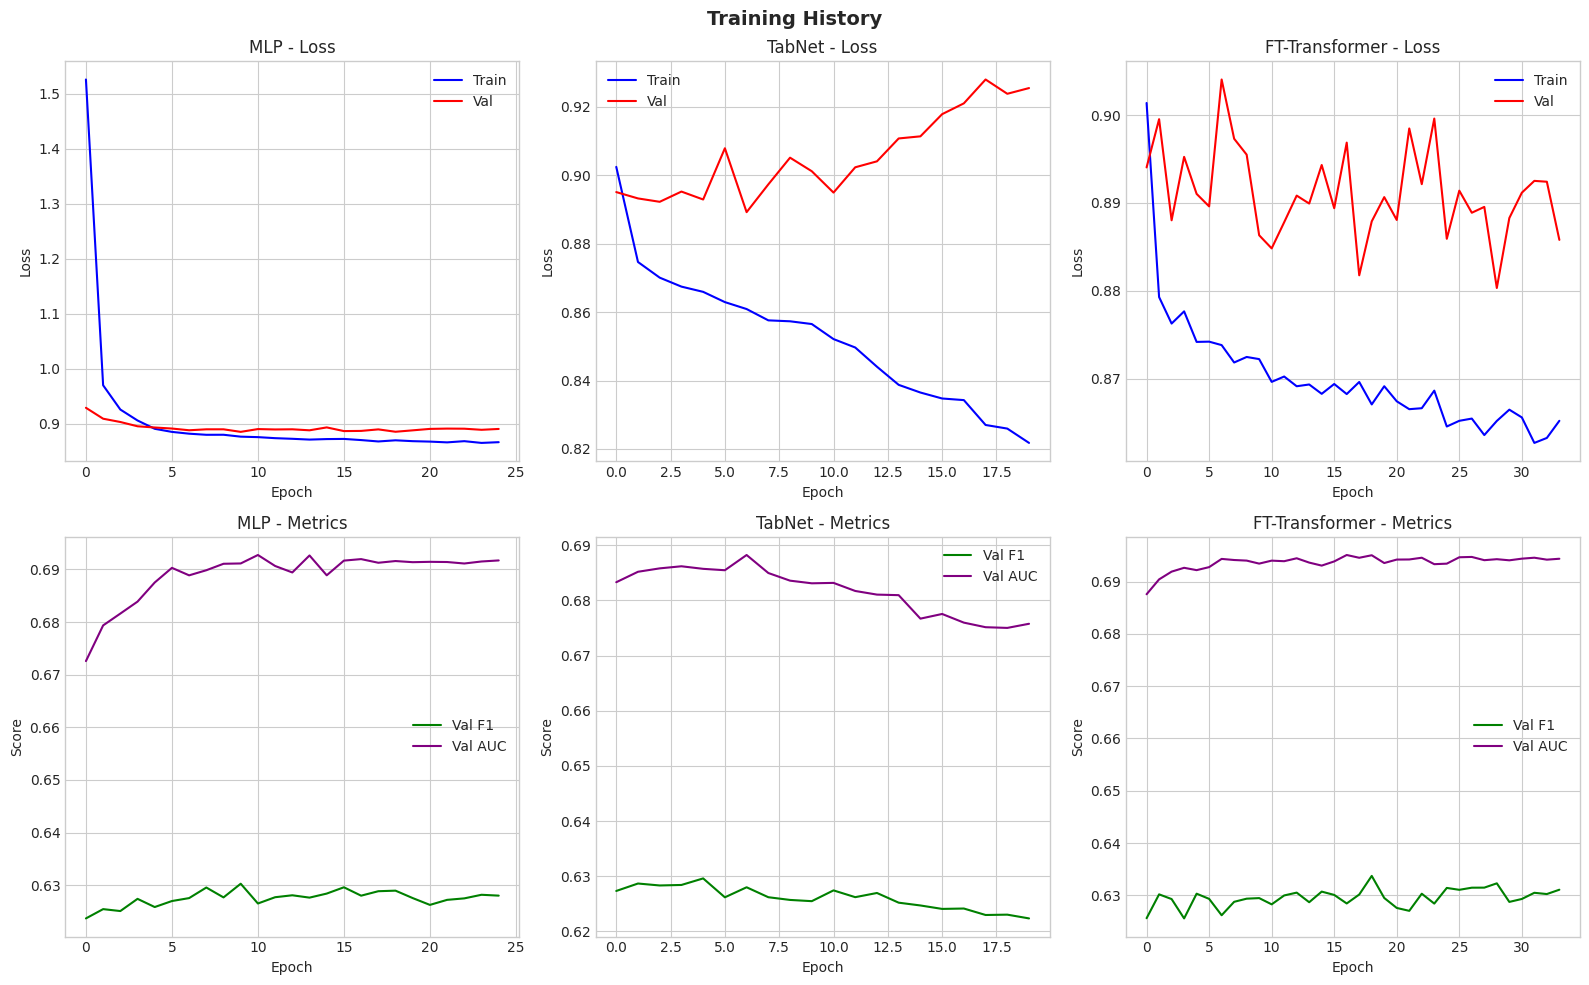

In [26]:
# Training history plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

histories = {
    'MLP': mlp_history,
    'TabNet': tabnet_history,
    'FT-Transformer': ft_history
}

colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (name, history) in enumerate(histories.items()):
    # Loss
    ax = axes[0, idx]
    ax.plot(history['train_loss'], label='Train', color='blue')
    ax.plot(history['val_loss'], label='Val', color='red')
    ax.set_title(f'{name} - Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    
    # F1 & AUC
    ax = axes[1, idx]
    ax.plot(history['val_f1'], label='Val F1', color='green')
    ax.plot(history['val_auc'], label='Val AUC', color='purple')
    ax.set_title(f'{name} - Metrics')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend()

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

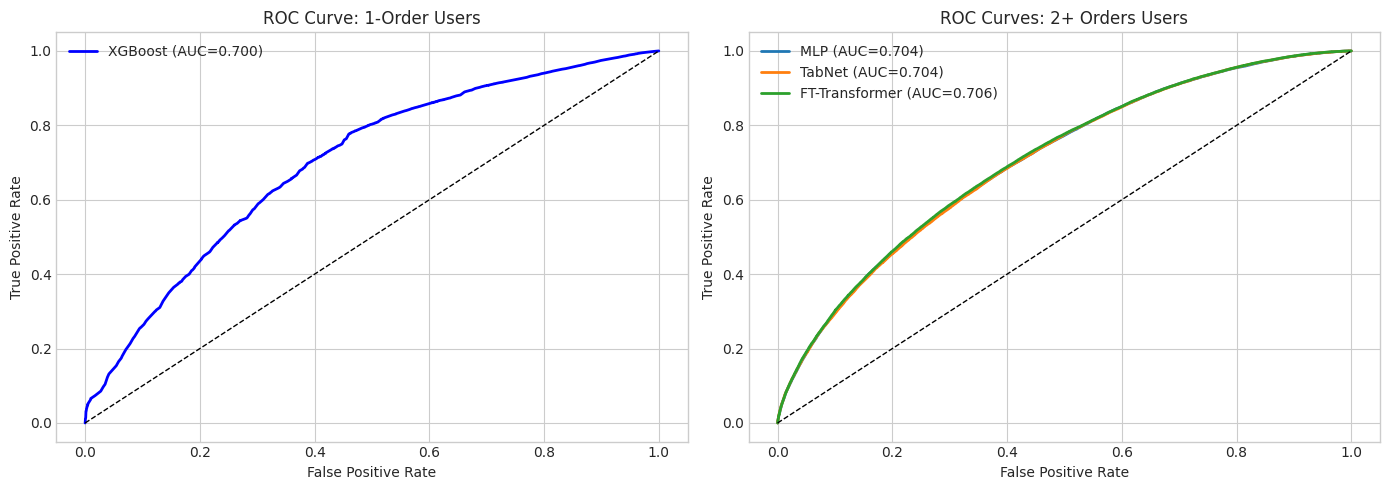

In [27]:
# ROC Curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1-Order (XGBoost)
ax = axes[0]
fpr, tpr, _ = roc_curve(y_test_1order, y_prob_1order)
auc = roc_auc_score(y_test_1order, y_prob_1order)
ax.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC={auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve: 1-Order Users')
ax.legend()

# 2+ Orders (All NNs)
ax = axes[1]
for name, (preds, probs) in nn_models_metrics.items():
    fpr, tpr, _ = roc_curve(y_test_multi, probs)
    auc = roc_auc_score(y_test_multi, probs)
    ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: 2+ Orders Users')
ax.legend()

plt.tight_layout()
plt.show()

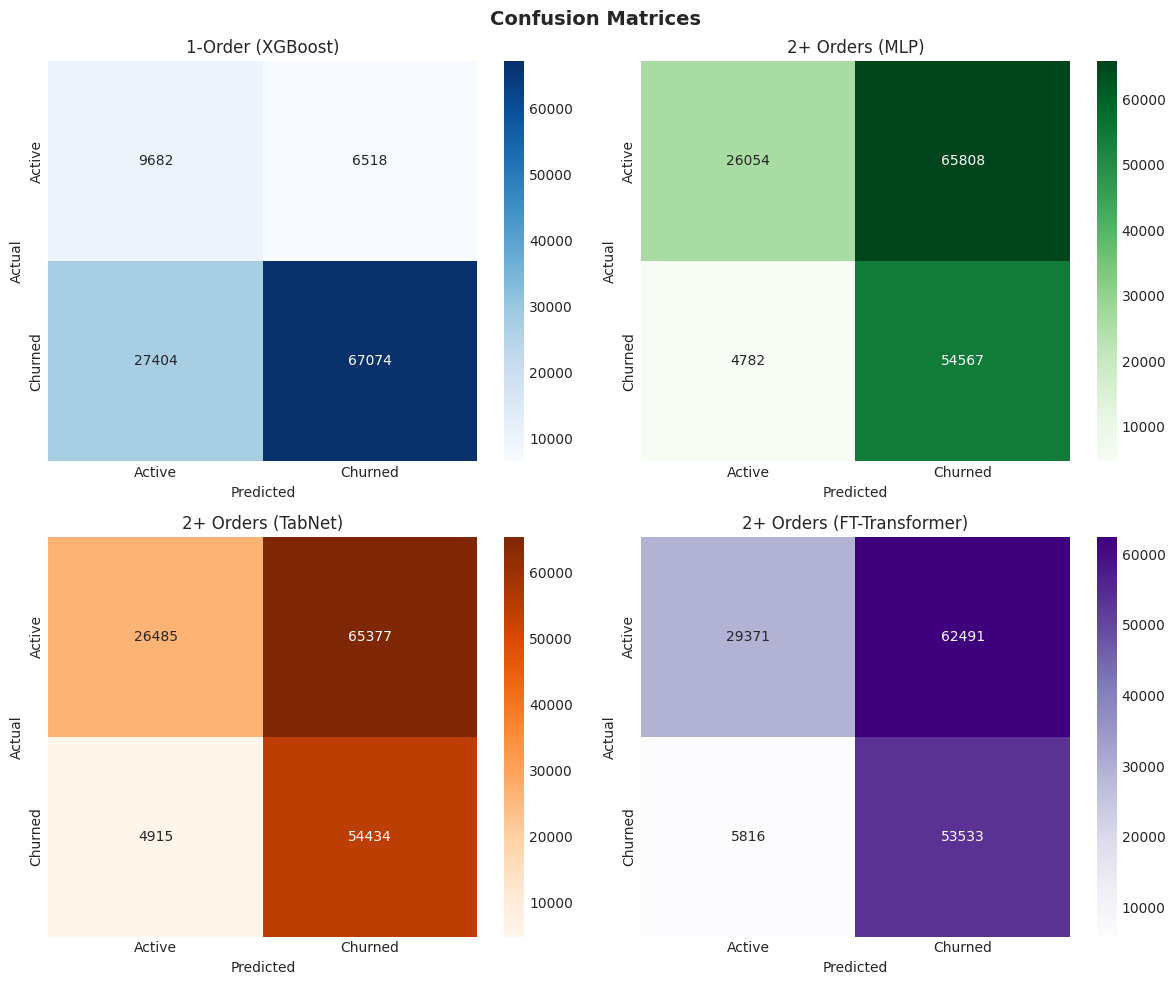

In [28]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1-Order
cm = confusion_matrix(y_test_1order, y_pred_1order)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
axes[0, 0].set_title('1-Order (XGBoost)')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2+ Orders - MLP
cm = confusion_matrix(y_test_multi, mlp_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
axes[0, 1].set_title('2+ Orders (MLP)')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 2+ Orders - TabNet
cm = confusion_matrix(y_test_multi, tabnet_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0],
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
axes[1, 0].set_title('2+ Orders (TabNet)')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 2+ Orders - FT-Transformer
cm = confusion_matrix(y_test_multi, ft_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[1, 1],
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
axes[1, 1].set_title('2+ Orders (FT-Transformer)')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

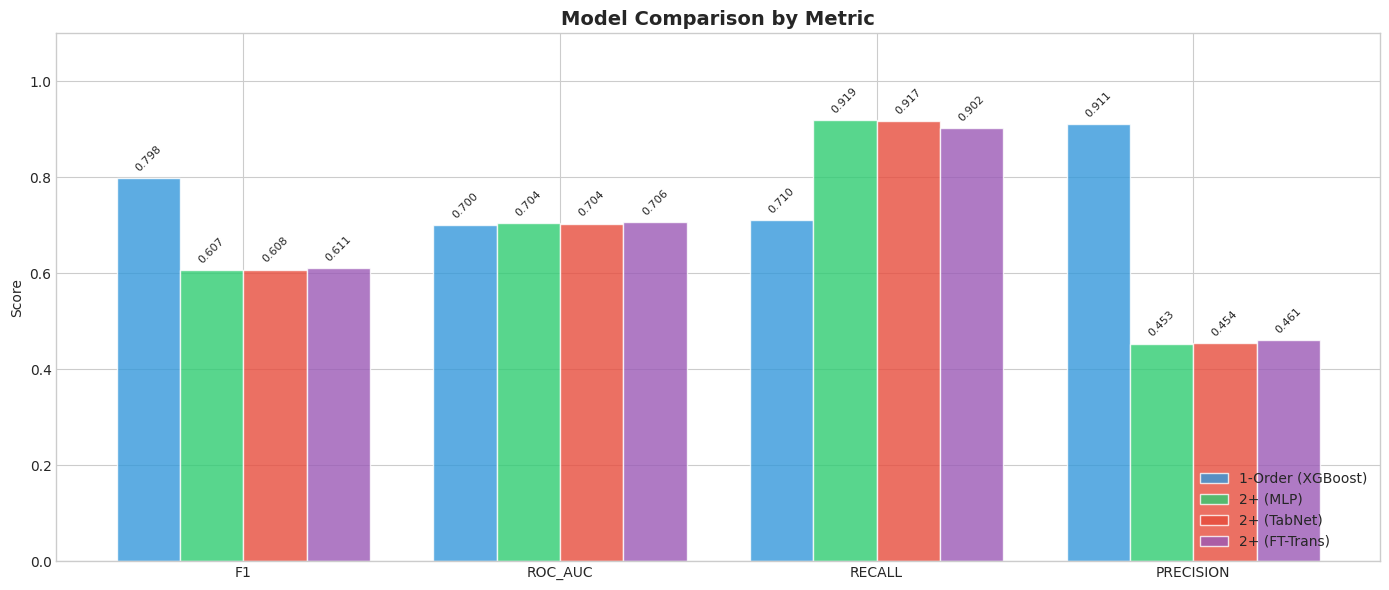

In [29]:
# Metrics comparison bar chart
fig, ax = plt.subplots(figsize=(14, 6))

metrics_to_plot = ['f1', 'roc_auc', 'recall', 'precision']
x = np.arange(len(metrics_to_plot))
width = 0.2

models_to_compare = [
    ('1-Order (XGBoost)', metrics_1order, '#3498db'),
    ('2+ (MLP)', mlp_metrics, '#2ecc71'),
    ('2+ (TabNet)', tabnet_metrics, '#e74c3c'),
    ('2+ (FT-Trans)', ft_metrics, '#9b59b6')
]

for i, (name, metrics, color) in enumerate(models_to_compare):
    values = [metrics[m] for m in metrics_to_plot]
    bars = ax.bar(x + i * width, values, width, label=name, color=color, alpha=0.8)
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=8, rotation=45)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([m.upper() for m in metrics_to_plot])
ax.set_ylabel('Score')
ax.set_title('Model Comparison by Metric', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

---
## 7️⃣ Save Models & Results

In [30]:
print('='*70)
print('💾 Saving Models & Results')
print('='*70)

results_dir = Path(CONFIG['results_dir'])
results_dir.mkdir(parents=True, exist_ok=True)

# Save XGBoost
with open(results_dir / 'xgboost_1order.pkl', 'wb') as f:
    pickle.dump(xgb_1order, f)
print('✅ Saved: xgboost_1order.pkl')

# Save PyTorch models
torch.save(mlp_model.state_dict(), results_dir / 'mlp_model.pt')
print('✅ Saved: mlp_model.pt')

torch.save(tabnet_model.state_dict(), results_dir / 'tabnet_model.pt')
print('✅ Saved: tabnet_model.pt')

torch.save(ft_model.state_dict(), results_dir / 'ft_transformer_model.pt')
print('✅ Saved: ft_transformer_model.pt')

# Save scaler
with open(results_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print('✅ Saved: scaler.pkl')

# Save results
results_df.to_csv(results_dir / 'per_group_results.csv')
overall_df.to_csv(results_dir / 'overall_results.csv')
print('✅ Saved: results CSVs')

# Save config
with open(results_dir / 'config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)
print('✅ Saved: config.json')

💾 Saving Models & Results
✅ Saved: xgboost_1order.pkl
✅ Saved: mlp_model.pt
✅ Saved: tabnet_model.pt
✅ Saved: ft_transformer_model.pt
✅ Saved: scaler.pkl
✅ Saved: results CSVs
✅ Saved: config.json


In [31]:
print('='*70)
print('📋 FINAL SUMMARY')
print('='*70)

print(f'''
🎯 STRATEGY:
   - 1-Order Users (45%): XGBoost (no behavioral patterns)
   - 2+ Orders Users (55%): Neural Networks (rich patterns)

📊 RESULTS BY GROUP:

👤 1-Order Users (XGBoost):
   F1: {metrics_1order["f1"]:.4f}
   AUC: {metrics_1order["roc_auc"]:.4f}
   Recall: {metrics_1order["recall"]:.4f}

👥 2+ Orders Users:
   MLP:            F1={mlp_metrics["f1"]:.4f}, AUC={mlp_metrics["roc_auc"]:.4f}
   TabNet:         F1={tabnet_metrics["f1"]:.4f}, AUC={tabnet_metrics["roc_auc"]:.4f}
   FT-Transformer: F1={ft_metrics["f1"]:.4f}, AUC={ft_metrics["roc_auc"]:.4f}

🏆 BEST COMBINATION:
   {best_overall}
   Overall F1: {overall_df.loc[best_overall, "f1"]:.4f}
   Overall AUC: {overall_df.loc[best_overall, "roc_auc"]:.4f}

💾 SAVED TO:
   {CONFIG["results_dir"]}/
''')

📋 FINAL SUMMARY

🎯 STRATEGY:
   - 1-Order Users (45%): XGBoost (no behavioral patterns)
   - 2+ Orders Users (55%): Neural Networks (rich patterns)

📊 RESULTS BY GROUP:

👤 1-Order Users (XGBoost):
   F1: 0.7982
   AUC: 0.7001
   Recall: 0.7099

👥 2+ Orders Users:
   MLP:            F1=0.6072, AUC=0.7044
   TabNet:         F1=0.6077, AUC=0.7036
   FT-Transformer: F1=0.6105, AUC=0.7064

🏆 BEST COMBINATION:
   XGBoost + FT-Transformer
   Overall F1: 0.7023
   Overall AUC: 0.5838

💾 SAVED TO:
   ../experiments/neural_networks/



---
## 8️⃣ Key Insights

In [32]:
print('='*70)
print('💡 KEY INSIGHTS')
print('='*70)

print('''
1️⃣ چرا XGBoost برای 1-Order بهتره؟
   - کاربرهای یک‌بار خرید پترن رفتاری ندارن
   - فیچرهای temporal (مثل avg_interval) برای اینا NaN یا 0 هست
   - Tree-based models با missing/sparse features بهتر کنار میان

2️⃣ مقایسه Neural Networks:
   - MLP: ساده‌ترین، baseline خوب
   - TabNet: Attention-based، feature importance داره
   - FT-Transformer: پیچیده‌ترین، نیاز به tuning بیشتر

3️⃣ توصیه‌ها:
   - برای Production: ترکیب XGBoost + بهترین NN
   - برای Interpretability: XGBoost + TabNet
   - برای Max Performance: Hyperparameter tuning روی FT-Transformer

4️⃣ بهبودهای ممکن:
   - Ensemble چند مدل
   - Hyperparameter optimization (Optuna)
   - Feature engineering بیشتر برای 1-Order users
   - Threshold optimization برای هر گروه
''')

💡 KEY INSIGHTS

1️⃣ چرا XGBoost برای 1-Order بهتره؟
   - کاربرهای یک‌بار خرید پترن رفتاری ندارن
   - فیچرهای temporal (مثل avg_interval) برای اینا NaN یا 0 هست
   - Tree-based models با missing/sparse features بهتر کنار میان

2️⃣ مقایسه Neural Networks:
   - MLP: ساده‌ترین، baseline خوب
   - TabNet: Attention-based، feature importance داره
   - FT-Transformer: پیچیده‌ترین، نیاز به tuning بیشتر

3️⃣ توصیه‌ها:
   - برای Production: ترکیب XGBoost + بهترین NN
   - برای Interpretability: XGBoost + TabNet
   - برای Max Performance: Hyperparameter tuning روی FT-Transformer

4️⃣ بهبودهای ممکن:
   - Ensemble چند مدل
   - Hyperparameter optimization (Optuna)
   - Feature engineering بیشتر برای 1-Order users
   - Threshold optimization برای هر گروه

